In [1]:
import pandas as pd #basically pandas is used to perform different analysis on data
import numpy as np #Numpy stands for numperical python used to perform numerical calculation on the data
import seaborn as sns #Seaborn and matplotlib both are used to visualise the different insights of data
import matplotlib.pyplot as plt

In [2]:
olist_customers_dataset=pd.read_csv("olist_customers_dataset.csv") 
olist_order_items_dataset=pd.read_csv("olist_order_items_dataset.csv")
olist_order_payments_dataset=pd.read_csv("olist_order_payments_dataset.csv")
olist_order_reviews_dataset=pd.read_csv("olist_order_reviews_dataset.csv")
olist_orders_dataset=pd.read_csv("olist_orders_dataset.csv")
olist_products_dataset=pd.read_csv("olist_products_dataset.csv")
olist_sellers_dataset=pd.read_csv("olist_sellers_dataset.csv")
product_category_name_translation=pd.read_csv("product_category_name_translation.csv")
olist_geolocation_dataset=pd.read_csv("olist_geolocation_dataset.csv")

In [3]:
merged_df = olist_orders_dataset.merge(olist_customers_dataset, on="customer_id", how="left")
merged_df = merged_df.merge(olist_order_reviews_dataset, on="order_id", how="left")
merged_df = merged_df.merge(olist_order_payments_dataset, on="order_id", how="left")
merged_df = merged_df.merge(olist_order_items_dataset, on="order_id", how="left")
merged_df = merged_df.merge(olist_products_dataset, on="product_id", how="left")
merged_df = merged_df.merge(olist_sellers_dataset, on="seller_id", how="left")

In [4]:
translation_dict = dict(zip(product_category_name_translation['product_category_name'], 
                            product_category_name_translation['product_category_name_english']))
def translate_category(category):
    if pd.isna(category):  
        return ""  
    words = category.split()  
    translated_words = [translation_dict.get(word, word) for word in words] 
    return ' '.join(translated_words)  
merged_df['product_category_name'] = merged_df['product_category_name'].apply(translate_category)

In [5]:
merged_df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_zip_code_prefix', 'customer_city',
       'customer_state', 'review_id', 'review_score', 'review_comment_title',
       'review_comment_message', 'review_creation_date',
       'review_answer_timestamp', 'payment_sequential', 'payment_type',
       'payment_installments', 'payment_value', 'order_item_id', 'product_id',
       'seller_id', 'shipping_limit_date', 'price', 'freight_value',
       'product_category_name', 'product_name_lenght',
       'product_description_lenght', 'product_photos_qty', 'product_weight_g',
       'product_length_cm', 'product_height_cm', 'product_width_cm',
       'seller_zip_code_prefix', 'seller_city', 'seller_state'],
      dtype='object')

In [6]:
def remove_outliers_iqr(df):
    Q1 = df.quantile(0.25)  # First quartile
    Q3 = df.quantile(0.75)  # Third quartile
    IQR = Q3 - Q1  # Interquartile range
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[~((df < lower_bound) | (df > upper_bound)).any(axis=1)]
df_numeric = merged_df.select_dtypes(include=['number'])
df_cleaned = remove_outliers_iqr(df_numeric)

In [7]:
df_non_numeric = merged_df.select_dtypes(exclude=['number'])

In [8]:
df_cleaned['order_id'] = merged_df['order_id']

/tmp/ipykernel_127648/4049919004.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_cleaned['order_id'] = merged_df['order_id']


In [9]:
df_non_numeric['order_id'] = merged_df['order_id']

In [10]:
df = pd.merge(df_non_numeric, df_cleaned, how='inner', on='order_id')

In [11]:
df.columns

Index(['order_id', 'customer_id', 'order_status', 'order_purchase_timestamp',
       'order_approved_at', 'order_delivered_carrier_date',
       'order_delivered_customer_date', 'order_estimated_delivery_date',
       'customer_unique_id', 'customer_city', 'customer_state', 'review_id',
       'review_comment_title', 'review_comment_message',
       'review_creation_date', 'review_answer_timestamp', 'payment_type',
       'product_id', 'seller_id', 'shipping_limit_date',
       'product_category_name', 'seller_city', 'seller_state',
       'customer_zip_code_prefix', 'review_score', 'payment_sequential',
       'payment_installments', 'payment_value', 'order_item_id', 'price',
       'freight_value', 'product_name_lenght', 'product_description_lenght',
       'product_photos_qty', 'product_weight_g', 'product_length_cm',
       'product_height_cm', 'product_width_cm', 'seller_zip_code_prefix'],
      dtype='object')

In [12]:
df["total_price_prod"]=((df["price"]+df["freight_value"])*df["order_item_id"])

In [13]:
import pickle
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans


Model trained and saved with segment labels!


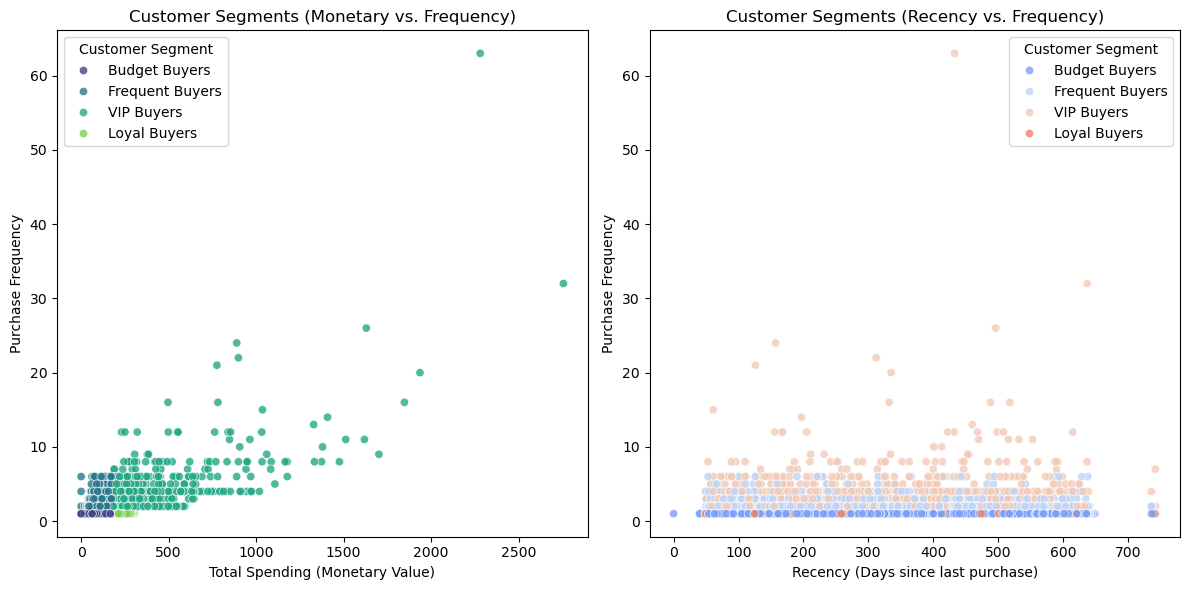

In [14]:
df["order_purchase_timestamp"] = pd.to_datetime(df["order_purchase_timestamp"])
latest_date = df["order_purchase_timestamp"].max()

# Computed RFM (Recency Frequency Monetory)
customer_data = df.groupby("customer_id").agg(
    recency=("order_purchase_timestamp", lambda x: (latest_date - x.max()).days),
    frequency=("order_id", "count"),
    monetary_value=("total_price_prod", "sum")
).reset_index()

# Standardized Data using standard scaler it is used for standardizing features by removing the mean and scaling to unit variance
scaler = StandardScaler()
scaled_features = scaler.fit_transform(customer_data[['recency', 'frequency', 'monetary_value']])
customer_data[['recency_z', 'frequency_z', 'monetary_z']] = scaled_features 

# Trained KMeans
kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
customer_data["cluster"] = kmeans.fit_predict(scaled_features)

# Computed Mean & Standard Deviation
rfm_mean = customer_data[['recency', 'frequency', 'monetary_value']].mean()
rfm_std = customer_data[['recency', 'frequency', 'monetary_value']].std()

# Assigned Segment Labels basically used the 
def assign_segment(row):
    recency_score = (row["recency"] - rfm_mean["recency"]) / rfm_std["recency"]
    frequency_score = (row["frequency"] - rfm_mean["frequency"]) / rfm_std["frequency"]
    monetary_score = (row["monetary_value"] - rfm_mean["monetary_value"]) / rfm_std["monetary_value"]

    if monetary_score > 1 and frequency_score > 1:
        return "VIP Buyers"
    elif monetary_score > 1:
        return "Loyal Buyers"
    elif frequency_score > 1:
        return "Frequent Buyers"
    else:
        return "Budget Buyers"

customer_data["segment"] = customer_data.apply(assign_segment, axis=1)

with open("rfm_kmeans.pkl", "wb") as model_file:
    pickle.dump((scaler, kmeans), model_file)

print("Model trained and saved with segment labels!")

plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.scatterplot(
    x=customer_data["monetary_value"],
    y=customer_data["frequency"],
    hue=customer_data["segment"],
    palette="viridis",
    alpha=0.8
)
plt.title("Customer Segments (Monetary vs. Frequency)")
plt.xlabel("Total Spending (Monetary Value)")
plt.ylabel("Purchase Frequency")
plt.legend(title="Customer Segment")
plt.subplot(1, 2, 2)
sns.scatterplot(
    x=customer_data["recency"],
    y=customer_data["frequency"],
    hue=customer_data["segment"],
    palette="coolwarm",
    alpha=0.8
)
plt.title("Customer Segments (Recency vs. Frequency)")
plt.xlabel("Recency (Days since last purchase)")
plt.ylabel("Purchase Frequency")
plt.legend(title="Customer Segment")

plt.tight_layout()
plt.show()

In [15]:
customer_data["segment"].value_counts()

segment
Budget Buyers      38214
Loyal Buyers        3720
Frequent Buyers     3455
VIP Buyers          1960
Name: count, dtype: int64

In [16]:
customer_data

,customer_id,recency,frequency,monetary_value,recency_z,frequency_z,monetary_z,cluster,segment
0,000379cdec625522490c315e70c7a9fb,197,1,107.01,-0.578850,-0.240258,0.107718,2,Budget Buyers
1,00050bf6e01e69d5c0fd612f1bcfb69c,394,1,85.23,0.702834,-0.240258,-0.173685,0,Budget Buyers
2,0005aefbb696d34b3424dccd0a0e9fd0,118,1,147.33,-1.092825,-0.240258,0.628662,2,Budget Buyers
3,00062b33cb9f6fe976afdcff967ea74d,579,1,58.95,1.906446,-0.240258,-0.513229,0,Budget Buyers
4,00072d033fe2e59061ae5c3aff1a2be5,410,1,106.97,0.806930,-0.240258,0.107201,0,Budget Buyers
...,...,...,...,...,...,...,...,...,...
47344,fffecc9f79fd8c764f843e9951b11341,201,3,244.08,-0.552826,2.480611,1.878695,1,VIP Buyers
47345,fffeda5b6d849fbd39689bb92087f431,147,1,63.13,-0.904151,-0.240258,-0.459222,2,Budget Buyers
47346,ffff42319e9b2d713724ae527742af25,125,1,214.13,-1.047283,-0.240258,1.491734,1,Loyal Buyers
47347,ffffa3172527f765de70084a7e53aae8,409,2,45.50,0.800424,1.120177,-0.687006,0,Frequent Buyers


In [17]:
rfm_mean

recency           285.971573
frequency           1.176604
monetary_value     98.672859
dtype: float64

In [18]:
rfm_std

recency           153.705644
frequency           0.735067
monetary_value     77.398750
dtype: float64